Re =  200.0


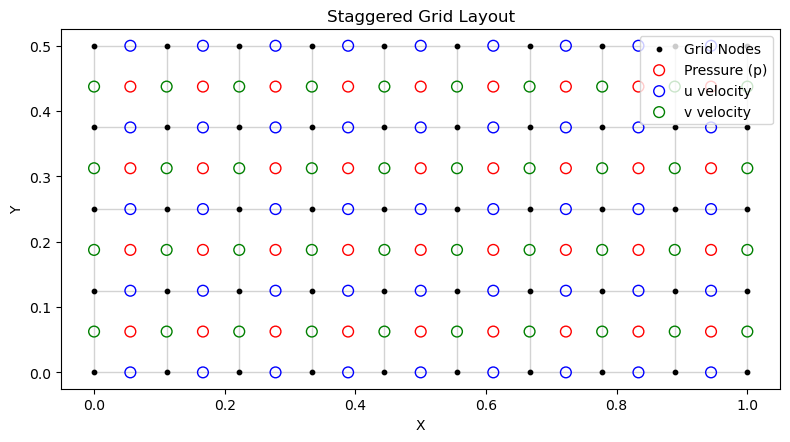

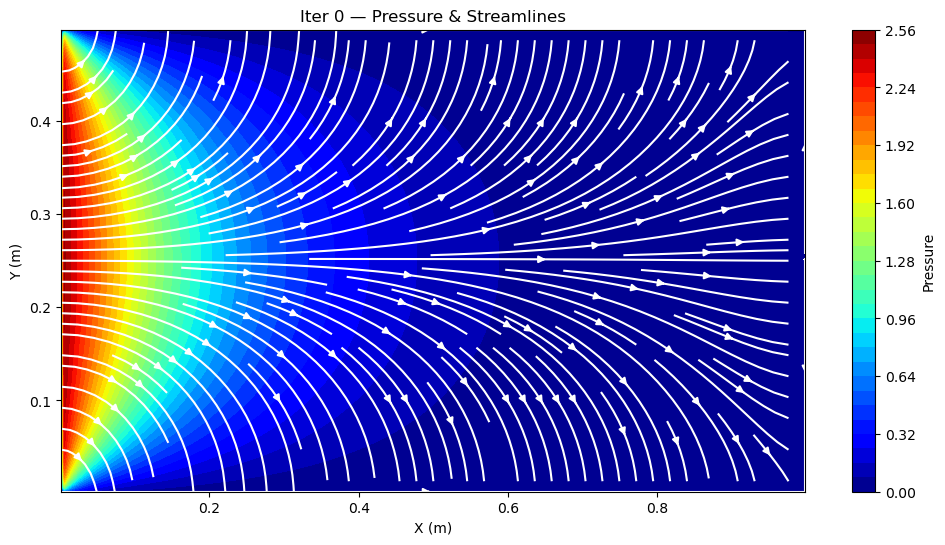

Iter 0, CFL=0.2550, Max u=1.000 m/s


KeyboardInterrupt: 

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags, linalg
from scipy.sparse.linalg import spsolve
from matplotlib import animation



class StaggeredGrid:
    def __init__(self, lx, ly, nx, ny):
        self.lx = lx
        self.ly = ly
        self.nx = nx
        self.ny = ny

        self.dx = lx / (nx - 1)
        self.dy = ly / (ny - 1)

        self.x_cell = np.linspace(0, lx, nx)
        self.y_cell = np.linspace(0, ly, ny)

        self.x_p = np.linspace(self.dx/2, lx - self.dx/2, nx-1)
        self.y_p = np.linspace(self.dy/2, ly - self.dy/2, ny-1)

        self.x_u = np.linspace(self.dx/2, lx - self.dx/2, nx-1)
        self.y_u = self.y_cell

        self.x_v = self.x_cell
        self.y_v = np.linspace(self.dy/2, ly - self.dy/2, ny-1)
        
    def plot_grid(self):
    # 创建图形
        fig, ax = plt.subplots(figsize=(8, 6))

    # 网格线（基于压力点坐标）
        for x in self.x_cell:
            ax.plot([x]*len(self.y_cell), self.y_cell, color='lightgray', linewidth=1, zorder=0)
        for y in self.y_cell:
            ax.plot(self.x_cell, [y]*len(self.x_cell), color='lightgray', linewidth=1, zorder=0)

    # 网格节点交点（黑色实心点）
        x_nodes, y_nodes = np.meshgrid(self.x_cell, self.y_cell, indexing='ij')
        ax.scatter(x_nodes, y_nodes, color='black', s=10, label='Grid Nodes')

    # 压力点（红色空心圆圈）
        xp, yp = np.meshgrid(self.x_p, self.y_p, indexing='ij')
        ax.scatter(xp, yp, facecolors='none', edgecolors='red', s=60, label='Pressure (p)')

    # u 点（蓝色空心圆圈）
        xu, yu = np.meshgrid(self.x_u, self.y_u, indexing='ij')
        ax.scatter(xu, yu, facecolors='none', edgecolors='blue', s=60, label='u velocity')

    # v 点（绿色空心圆圈）
        xv, yv = np.meshgrid(self.x_v, self.y_v, indexing='ij')
        ax.scatter(xv, yv, facecolors='none', edgecolors='green', s=60, label='v velocity')

    # 图形属性设置
        ax.set_aspect('equal')
        ax.set_title("Staggered Grid Layout")
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.legend(loc='upper right')
        #ax.grid(True, which='both', linestyle='--', linewidth=0.5)
        plt.tight_layout()
        plt.show()



class FluidSolver:
    def __init__(self, grid, U0,Uin ,L0, nu):
        self.grid = grid
        self.U0 = U0
        self.L0 = L0
        self.nu = nu
        self.Uin = Uin

        self.Re = U0 * L0 / nu

        self.u = np.zeros((grid.nx-1, grid.ny))
        self.v = np.zeros((grid.nx, grid.ny-1))
        self.p = np.zeros((grid.nx-1,grid.ny-1))

    def apply_velocity_bc(self):
        self.u[0, :] = self.Uin / self.U0
        self.v[0, :] = 0.0

        self.u[-1, :] = self.u[-2, :]
        self.v[-1, :] = self.v[-2, :]
        self.p[-1, :] = self.p[-2, :]
        self.p[0, :] = 0.0  # 左侧设为参考压力（大气压）


        self.v[:, 0] = 0.0
        self.v[:, -1] = 0.0

        self.u[:, 0] = 0
        self.u[:, -1] = 0

    def solve_momentum(self, dt):
        u_star = self.u.copy()
        v_star = self.v.copy()
        dx, dy = self.grid.dx, self.grid.dy
        Re = self.Re
        

        i_min = 1
        j_min = 1
        i_max = self.grid.nx-1 -1
        j_max = self.grid.ny-1 -1

        #u 动量离散
        for i in range(1,self.grid.nx - 1 - 1):
            for j in range(1,self.grid.ny-1-1):
                d2udx2 = (self.u[i + 1, j] - 2 * self.u[i, j] + self.u[i - 1, j]) / dx**2
                d2udy2 = (self.u[i, j + 1] - 2 * self.u[i, j] + self.u[i, j - 1]) / dy**2
                diff = (d2udx2 + d2udy2) / Re

                ududx = self.u[i, j]*(self.u[i+1, j] - self.u[i-1, j]) / (2*dx)

                va = 0.5 * (self.v[i - 1, j ] + self.v[i-1, j+1 ])
                vb = 0.5 * (self.v[i , j ] + self.v[i, j + 1])
                v = 0.5*(va+vb)
                vdudy = v*(self.v[i, j+1] - self.v[i, j-1]) / (2*dy)

                conv = vdudy + ududx
                u_star[i, j] += dt * ( -conv + diff)

        
        # v 动量离散
        for i in range(1, self.grid.nx - 1-1):
            for j in range(1, self.grid.ny - 1 - 1):
        # -------- 扩散项 --------
                d2vdx2 = (self.v[i + 1, j] - 2 * self.v[i, j] + self.v[i - 1, j]) / dx**2
                d2vdy2 = (self.v[i, j + 1] - 2 * self.v[i, j] + self.v[i, j - 1]) / dy**2
                diff = (d2vdx2 + d2vdy2) / Re

        # -------- 对流项：vdvdy --------
                dvdy = (self.v[i, j + 1] - self.v[i, j-1]) / (2*dy)
                vdvdy = dvdy * (self.v[i, j])

        # -------- 对流项：udvdx --------
                ua = 0.5 * (self.u[i, j - 1] + self.u[i, j])
                ub = 0.5 * (self.u[i + 1, j - 1] + self.u[i + 1, j])
                u = 0.5 * (ua + ub)
                dvdx = (self.v[i + 1, j] - self.v[i-1, j]) /  (2*dy)
                udvdx = dvdx * u

        # -------- 合并更新 --------
                conv = udvdx + vdvdy
                v_star[i, j] += dt * (-conv + diff)


        self.u, self.v = u_star, v_star

    def build_poisson_matrix(self):
        nx, ny = self.grid.nx - 1, self.grid.ny - 1
        N = nx * ny
        dx, dy = self.grid.dx, self.grid.dy

        main_diag = -2 * (1 / dx**2 + 1 / dy**2) * np.ones(N)
        x_diag = (1 / dx**2) * np.ones(N - 1)
        x_diag[np.arange(1, N) % ny == 0] = 0
        y_diag = (1 / dy**2) * np.ones(N - ny)

        A = diags([main_diag, x_diag, x_diag, y_diag, y_diag], [0, 1, -1, ny, -ny])
        return A.tocsr()

    def solve_pressure_correction(self, dt):
        dx, dy = self.grid.dx, self.grid.dy
        nx, ny = self.grid.nx - 1, self.grid.ny - 1

        div_u = np.zeros((nx, ny))
        for i in range(1,nx - 1):  # 修复这里
            for j in range(1,ny - 1):  # 修复这里
                div_u[i, j] = (self.u[i + 1, j] - self.u[i, j]) / dx + \
                          (self.v[i, j + 1] - self.v[i, j]) / dy

        A = self.build_poisson_matrix()
        b = div_u.flatten() / dt

        p_corr = spsolve(A, b).reshape(nx, ny)
        return p_corr
    
    def define_cylinder(self, center, radius):
        self.cylinder_center = center
        self.cylinder_radius = radius
    
    def apply_IBM(self):
        cx, cy = self.cylinder_center
        r = self.cylinder_radius
        dx, dy = self.grid.dx, self.grid.dy

    # 修正 u 点
        for i in range(self.u.shape[0]):
            for j in range(self.u.shape[1]):
                x = self.grid.x_u[i]
                y = self.grid.y_u[j]
                if (x - cx)**2 + (y - cy)**2 <= r**2:
                    self.u[i, j] = 0.0

    # 修正 v 点
        for i in range(self.v.shape[0]):
            for j in range(self.v.shape[1]):
                x = self.grid.x_v[i]
                y = self.grid.y_v[j]
                if (x - cx)**2 + (y - cy)**2 <= r**2:
                    self.v[i, j] = 0.0




    def correct_fields(self, p_corr, dt):
        dx, dy = self.grid.dx, self.grid.dy

        #self.p += p_corr
        self.p = p_corr

        for i in range(1, self.grid.nx - 2):
            for j in range(1,self.grid.ny - 1):
                self.u[i, j] -= dt * (p_corr[i, j] - p_corr[i - 1, j]) / dx

        for i in range(1,self.grid.nx - 1):
            for j in range(1, self.grid.ny - 2):
                self.v[i, j] -= dt * (p_corr[i, j] - p_corr[i, j - 1]) / dy

    def compute_cfl(self, dt):
        dx, dy = self.grid.dx, self.grid.dy
        cfl_u = np.max(np.abs(self.u)) * dt / dx
        cfl_v = np.max(np.abs(self.v)) * dt / dy
        return max(cfl_u, cfl_v)

    def plot_live_streamlines(self, ax, iter,fig):
        ax.clear()  # 清除旧内容，但保持画布

        x_p = self.grid.x_p
        y_p = self.grid.y_p
        X, Y = np.meshgrid(x_p, y_p, indexing='ij')

        u_center = 0.5 * (self.u[:, :-1] + self.u[:, 1:])
        v_center = 0.5 * (self.v[:-1, :] + self.v[1:, :])

        contf = ax.contourf(X, Y, self.p, levels=32, cmap='jet')
        if iter == 0:  # 只加一次 colorbar
            plt.colorbar(contf, ax=ax, label='Pressure')

        ax.streamplot(x_p, y_p, u_center.T, v_center.T, color='white', density=1.5)
        ax.set_title(f"Iter {iter} — Pressure & Streamlines")
        ax.set_xlabel('X (m)')
        ax.set_ylabel('Y (m)')
        # ✅ 固定坐标轴范围
        ax.set_xlim(x_p[0], x_p[-1])
        ax.set_ylim(y_p[0], y_p[-1])

        fig.canvas.draw()
        fig.canvas.flush_events()





def main():
    lx, ly = 1.0, 0.5  # 单位：米
    nx, ny = 256, 128
    U0 = 1  # m/s
    nu = 5e-3  # 动力粘性系数 (m^2/s)
    L0 = lx
    Uin = 1.0
    Re = U0 * L0 / nu
    print("Re = ",Re)

    # 设置圆柱参数
    cylinder_center = (0.2, 0.25)  # 圆心坐标 (x, y)
    cylinder_radius = 0.1         # 半径
        

    grid = StaggeredGrid(1, 0.5, 10, 5)
    grid.plot_grid()
    grid = StaggeredGrid(lx,ly,nx,ny)
    solver = FluidSolver(grid, U0,Uin ,L0, nu)
    solver.define_cylinder(cylinder_center, cylinder_radius)


    dt = 0.001
    max_iter = 2000

    # 初始化动画图形
    plt.ion()
    fig, ax = plt.subplots(figsize=(12, 6))


    for iter in range(max_iter):
        solver.apply_velocity_bc()
        solver.solve_momentum(dt)
        solver.apply_IBM()  # 🔥 在动量后强制设定障碍物速度

        p_corr = solver.solve_pressure_correction(dt)
        solver.correct_fields(p_corr, dt)
        
        if iter % 5 == 0:
            solver.plot_live_streamlines(ax, iter,fig)
            plt.pause(0.001)  # 动画刷新


        if iter % 100 == 0:
            cfl = solver.compute_cfl(dt)
            print(f"Iter {iter}, CFL={cfl:.4f}, Max u={np.max(solver.u)*U0:.3f} m/s")

   # 构造压力网格坐标 (nx-1, ny-1)
    x_p = grid.x_p
    y_p = grid.y_p
    X, Y = np.meshgrid(x_p, y_p, indexing='ij')

# 插值速度到压力点 (nx-1, ny-1)
    u_center = 0.5 * (solver.u[:, :-1] + solver.u[:, 1:])   # (nx-1, ny-1)
    v_center = 0.5 * (solver.v[:-1, :] + solver.v[1:, :])   # (nx-1, ny-1)

# ============ ✅ 绘图 ============
    plt.figure(figsize=(12, 6))
    plt.contourf(X, Y, solver.p, levels=32, cmap='jet')
    plt.colorbar(label='Pressure')
    plt.streamplot(x_p, y_p, u_center.T, v_center.T, color='white', density=1.5)
    plt.title('Staggered Grid Simulation Results')
    plt.xlabel('X (m)')
    plt.ylabel('Y (m)')
    plt.tight_layout()

    plt.show()
    




if __name__ == "__main__":
    main()


